In [303]:
import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
import zipfile
import sys
import requests, io
import re 
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [304]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(sim.size):
#         print(TP, FP, FN, TN)
        if df['need_match'][i]:
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [305]:
class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
        elif model == "fast_text":
            print("fast_text")
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
#                 print(f'index_to_key: {self.model.wv.index_to_key}')
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            for i in steps:
                sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
                threshold = calc_f1_score(sim, df, h)
                thresholds.append(threshold)
                print(h, threshold)
                if threshold > max_:
                    max_ = threshold
                h += step
            plt.plot(steps, thresholds)
            plt.show()
            
            return max_

## Обучим word2vec

In [306]:
data_df = read_json('./preprocessed_documents.json')
modelResearcher_w2v = ModelResearcher()
# modelResearcher_w2v.train(data_df, model="w2v")
modelResearcher_w2v.model = models.ldamodel.LdaModel.load('./w2v')
modelResearcher_w2v.model

In [315]:
match_unmatch_df = read_json('./dataset.json')

In [316]:
df_train_f1 = pd.concat([pd.DataFrame(match_unmatch_df[0:17]), pd.DataFrame(match_unmatch_df[30:])], axis=0)
df_test_f1 = pd.DataFrame(match_unmatch_df[17:30])

In [317]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size,match_unmatch_df['id_rp'].size))

df_train: 33 of 46
df_test: 13 of 46


In [318]:
# df_train_f1

In [319]:
df_train_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_train_f1, None, 'text_rp', 'text_proj')
df_test_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_test_f1, None, 'text_rp', 'text_proj')

In [320]:
# result_w2v_train = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
# df_train_f1

In [321]:
# df_test_f1

0.02 0.68
0.04 0.68
0.06 0.68
0.08 0.68
0.1 0.68
0.12000000000000001 0.68
0.14 0.68
0.16 0.68
0.18 0.68
0.19999999999999998 0.68
0.21999999999999997 0.68
0.23999999999999996 0.68
0.25999999999999995 0.68
0.27999999999999997 0.68
0.3 0.68
0.32 0.68
0.34 0.68
0.36000000000000004 0.68
0.38000000000000006 0.68
0.4000000000000001 0.694
0.4200000000000001 0.694
0.4400000000000001 0.694
0.46000000000000013 0.694
0.48000000000000015 0.694
0.5000000000000001 0.694
0.5200000000000001 0.694
0.5400000000000001 0.708
0.5600000000000002 0.708
0.5800000000000002 0.723
0.6000000000000002 0.723
0.6200000000000002 0.696
0.6400000000000002 0.667
0.6600000000000003 0.698
0.6800000000000003 0.7
0.7000000000000003 0.718
0.7200000000000003 0.737
0.7400000000000003 0.743
0.7600000000000003 0.75
0.7800000000000004 0.759
0.8000000000000004 0.667
0.8200000000000004 0.435
0.8400000000000004 0.364
0.8600000000000004 0.364
0.8800000000000004 0.3
0.9000000000000005 0.211
0.9200000000000005 0.0
0.9400000000000005 0.0

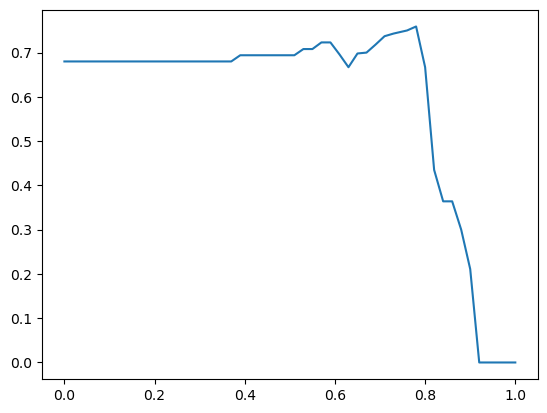

In [322]:
result_w2v_train_opt = modelResearcher_w2v.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [323]:
print(result_w2v_train_opt)

0.759


In [324]:
f1_w2v_train = calc_f1_score(result_w2v_train, df_train_f1, result_w2v_train_opt)
print('F1-score train w2v: {}'.format(f1_w2v_train ))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_w2v) 
# df_train_f1

F1-score train w2v: 0.774


In [325]:
result_w2v_test = modelResearcher_w2v.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_w2v_test = calc_f1_score(result_w2v_test, df_test_f1, result_w2v_train_opt)
print('F1-score test w2v: {}'.format(f1_w2v_test))

F1-score test w2v: 0.833


In [ ]:
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_w2v_test) 
df_test_f1[8:]

## FastText

In [ ]:
# modelResearcher_ft = ModelResearcher()
# data_df = read_json('./preprocessed_documents.json')
# modelResearcher_ft.train(data_df, model="fast_text")
# modelResearcher_ft.model.save('ft')

In [326]:
modelResearcher_ft.model = None

In [327]:
modelResearcher_ft = ModelResearcher()
modelResearcher_ft.model = models.ldamodel.LdaModel.load('./ft')

In [328]:

# f1_ft_train = calc_f1_score(result_ft_train, df_train_f1, 0.78)
# print('F1-score train ft: {}'.format(f1_ft_train ))

# result_ft_test = modelResearcher_ft.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
# f1_ft_test = calc_f1_score(result_ft_test, df_test_f1, 0.78)
# print('F1-score test ft: {}'.format(f1_ft_test ))

0.02 0.68
0.04 0.68
0.06 0.68
0.08 0.68
0.1 0.68
0.12000000000000001 0.68
0.14 0.68
0.16 0.68
0.18 0.68
0.19999999999999998 0.68
0.21999999999999997 0.68
0.23999999999999996 0.68
0.25999999999999995 0.68
0.27999999999999997 0.68
0.3 0.68
0.32 0.68
0.34 0.68
0.36000000000000004 0.68
0.38000000000000006 0.68
0.4000000000000001 0.68
0.4200000000000001 0.68
0.4400000000000001 0.68
0.46000000000000013 0.68
0.48000000000000015 0.68
0.5000000000000001 0.68
0.5200000000000001 0.68
0.5400000000000001 0.68
0.5600000000000002 0.68
0.5800000000000002 0.68
0.6000000000000002 0.68
0.6200000000000002 0.68
0.6400000000000002 0.68
0.6600000000000003 0.68
0.6800000000000003 0.708
0.7000000000000003 0.696
0.7200000000000003 0.696
0.7400000000000003 0.711
0.7600000000000003 0.682
0.7800000000000004 0.667
0.8000000000000004 0.718
0.8200000000000004 0.824
0.8400000000000004 0.788
0.8600000000000004 0.615
0.8800000000000004 0.5
0.9000000000000005 0.286
0.9200000000000005 0.211
0.9400000000000005 0.211
0.9600

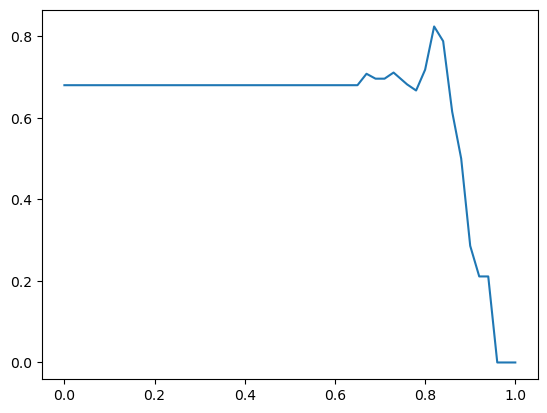

In [329]:
result_ft_train_opt = modelResearcher_ft.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [291]:
print(result_ft_train_opt)

0.824


In [292]:
result_ft_train = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
f1_ft_train = calc_f1_score(result_ft_train, df_train_f1, result_ft_train_opt)
print('F1-score train ft: {}'.format(f1_ft_train ))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_ft_train) 

F1-score train ft: 0.824


In [232]:
result_ft_test = modelResearcher_ft.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_ft_test = calc_f1_score(result_ft_test, df_test_f1, result_ft_train_opt)
print('F1-score test ft: {}'.format(f1_ft_test))
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_ft_test) 

F1-score test ft: 0.833
